In [19]:
from pandas.io.xml import preprocess_data
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def load_dataset(path:str)->pd.DataFrame:
    """
    Load the dataset from a csv file in the given path
    :param path: path in string
    :return: pd.Dataframe of the data
    """
    return pd.read_csv(path)

In [21]:
raw_data = load_dataset("../data/raw_data/credit_card_fraud_dataset.csv")

In [22]:
def data_exploration(data:pd.DataFrame)->None:
    '''
    print out the basic information of the data
    first 5 head of the data,
    data description,
    data info,
    data decription of only int and float type,
    number of null values in each column
    :param data: data to be explored in pd.DataFrame
    :return: returns nothing
    '''
    print('Data Head')
    print(data.head())
    print('='*100)
    print('Data Description')
    print(data.describe(include='all'))
    print('='*100)
    print('Data Info')
    print(data.info())
    print('='*100)
    print('Data Description of only int and float type')
    data_numeric=data.select_dtypes(include=['int', 'float'])
    print(data_numeric.describe())
    print('='*100)
    print('Data Description of object type')
    data_numeric=data.select_dtypes(include='object')
    print(data_numeric.describe())
    print('='*100)
    print('Number of null values in each column')
    print(data.isnull().sum())

In [23]:
data_exploration(raw_data)

Data Head
   TransactionID             TransactionDate   Amount  MerchantID  \
0              1  2024-04-03 14:15:35.462794  4189.27         688   
1              2  2024-03-19 13:20:35.462824  2659.71         109   
2              3  2024-01-08 10:08:35.462834   784.00         394   
3              4  2024-04-13 23:50:35.462850  3514.40         944   
4              5  2024-07-12 18:51:35.462858   369.07         475   

  TransactionType      Location  IsFraud  
0          refund   San Antonio        0  
1          refund        Dallas        0  
2        purchase      New York        0  
3        purchase  Philadelphia        0  
4        purchase       Phoenix        0  
Data Description
        TransactionID             TransactionDate         Amount  \
count   100000.000000                      100000  100000.000000   
unique            NaN                      100000            NaN   
top               NaN  2024-05-20 18:56:36.027551            NaN   
freq              NaN       

In [24]:
def draw_fraud_distribution(data:pd.DataFrame,file_name:str)->None:
    '''
    Draw the bar graph of Fraud and Not Fraud distribution and save it to the assets folder
    :param data: pd.DataFrame, contains the data
    :param file_name:  str, the name of the file to be saved
    :return: None
    '''
    sns.set(style="whitegrid")

    # Plot distribution of fraud vs non-fraud
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=data, x='IsFraud', hue='IsFraud', palette='viridis')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Not Fraud', 'Fraud'])
    ax.set_title('Transaction Fraud Distribution')
    ax.set_xlabel('Transaction Type')
    ax.set_ylabel('Count')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.savefig(f'../assets/figures/{file_name}')

    plt.show()


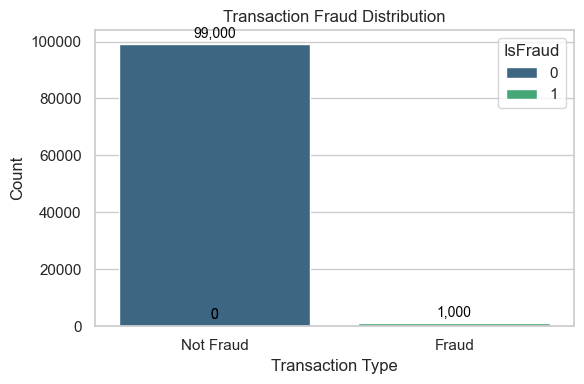

In [25]:
draw_fraud_distribution(raw_data,'fraud_distribution')

In [37]:
print(f"Fraud to not fraud ratio: {(raw_data['IsFraud']==1).sum()/(raw_data['IsFraud']==0).sum()}")

Fraud to not fraud ratio: 0.010101010101010102


In [26]:
def plot_amount_distribution(data:pd.DataFrame)->None:
    '''
    Plot the amount distribution w.r.t fraud classes and save to the assets folder
    :param data: pd.DataFrame, contains the data
    :return: returns none
    '''
    plt.figure(figsize=(12, 6))

    # Create two subplots
    plt.subplot(1, 2, 1)
    sns.boxplot(x='IsFraud', y='Amount', data=data)
    plt.title('Transaction Amount Distribution\nby Fraud Status')
    plt.xlabel('Is Fraudulent')
    plt.ylabel('Amount')

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x='Amount', hue='IsFraud', multiple="stack", bins=30)
    plt.title('Transaction Amount Distribution')
    plt.xlabel('Amount')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('../assets/figures/amount_analysis.png')
    plt.show()


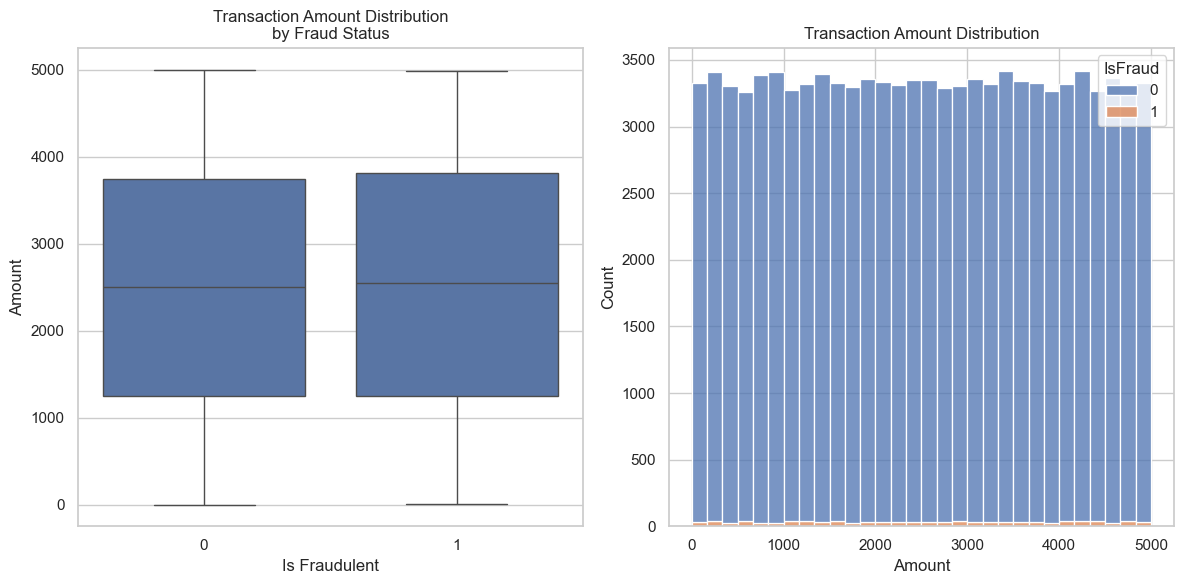

In [27]:
plot_amount_distribution(raw_data)

In [28]:
def plot_transaction_type_analysis(data:pd.DataFrame)->None:
    '''
    Plot the transaction type analysis w.r.t fraud and non fraud. Also save the plot
    :param data:pd.DataFrame, contains the data
    :return:None
    '''
    plt.figure(figsize=(10, 6))

    # Create cross-tabulation of TransactionType and IsFraud
    fraud_by_type = pd.crosstab(data['TransactionType'], data['IsFraud'])

    # Plot stacked bar chart
    fraud_by_type.plot(kind='bar', stacked=True)
    plt.title('Transaction Types: Fraudulent vs Non-Fraudulent')
    plt.xlabel('Transaction Type')
    plt.ylabel('Number of Transactions')
    plt.legend(['Non-Fraudulent', 'Fraudulent'])

    plt.tight_layout()
    plt.savefig('../assets/figures/transaction_type_analysis.png')
    plt.show()


<Figure size 1000x600 with 0 Axes>

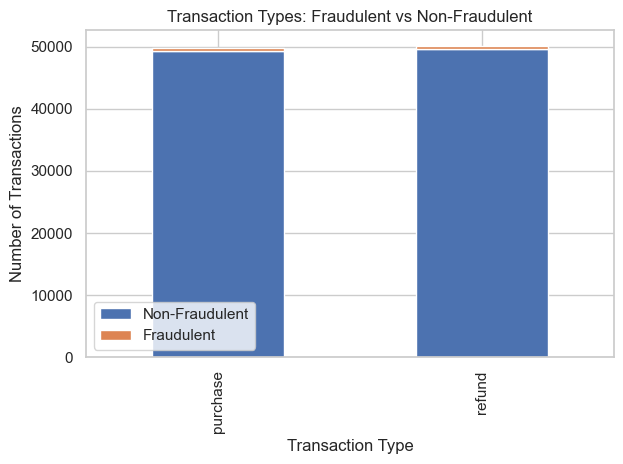

In [29]:
plot_transaction_type_analysis(raw_data)

In [30]:
def plot_location_analysis(data:pd.DataFrame)->None:
    '''
    Plot the fraud percentage analysis w.r.t location. Also save the plot
    :param data: pd.DataFrame, contains the data
    :return: None
    '''
    plt.figure(figsize=(12, 6))

    # Get fraud percentage by location
    location_fraud = data.groupby('Location')['IsFraud'].mean() * 100
    location_fraud = location_fraud.sort_values(ascending=False)

    ax = sns.barplot(x=location_fraud.index, y=location_fraud.values)
    plt.title('Fraud Percentage by Location')
    plt.xlabel('Location')
    plt.ylabel('Fraud Percentage')
    plt.xticks(rotation=45)

    # Add percentage labels
    for i, v in enumerate(location_fraud.values):
        ax.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('../assets/figures/location_analysis.png')
    plt.show()


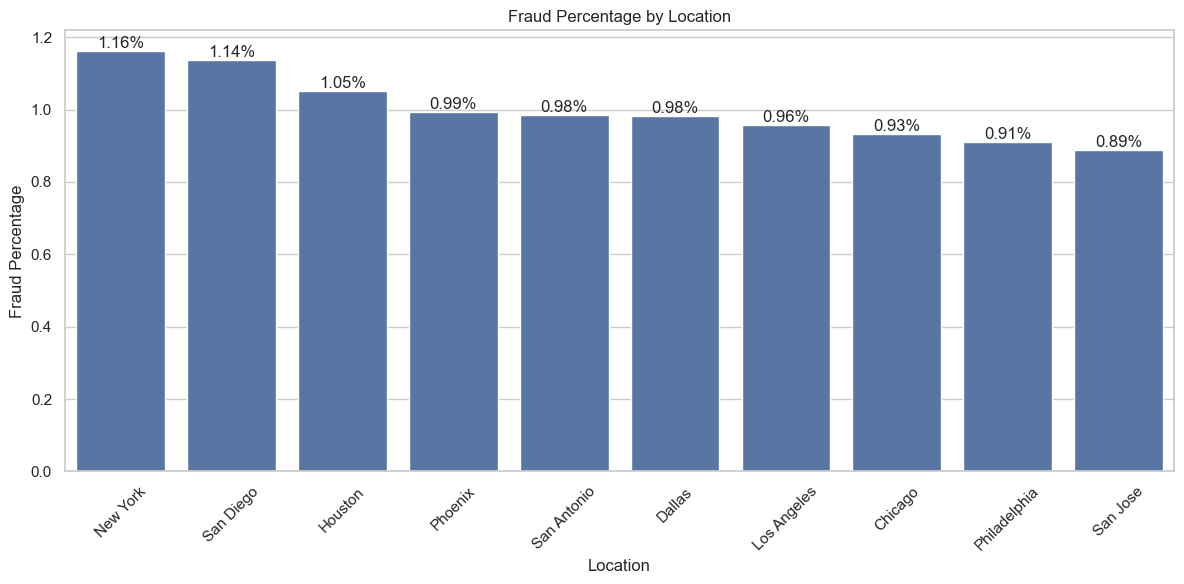

In [31]:
plot_location_analysis(raw_data)

In [32]:

def process_date(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Process the date column so the model can handle it better. Also convert the time to a cyclical encoding so the model can understand temporal distance better. It also save the plot.
    :param data: Pandas DataFrame, contains the data
    :return:None
    '''
    data = data.copy()
    data["TransactionDate"] = pd.to_datetime(data["TransactionDate"], errors='coerce')

    # Extract time-based features
    data['Hour'] = data["TransactionDate"].dt.hour
    data['DayOfWeek'] = data['TransactionDate'].dt.dayofweek  # 0=Monday
    data['Day'] = data['TransactionDate'].dt.day
    data['Month'] = data['TransactionDate'].dt.month
    data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)

    # Cyclical encoding for Hour
    data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

    # Drop original columns
    data.drop(['TransactionDate', 'Hour'], axis=1, inplace=True)

    return data


In [33]:
data=process_date(raw_data)

In [34]:
def pre_processing(data:pd.DataFrame,save_path:str)->pd.DataFrame:
    '''
    Drop useless columns and transform the data. It saves the processed data to a csv file in data/processed_data folder.
    :param data: pd.DataFrame, contains the data
    :param save_path: str, the path where the processed data will be saved
    :return: pd.DataFrame, contains the processed data head()
    '''
    df_copy = data.copy()
    df_copy=df_copy.drop("TransactionID",axis=1)
    le=LabelEncoder()
    cat_cols=df_copy.select_dtypes(include=['object']).columns
    for cols in cat_cols:
        df_copy[cols]=le.fit_transform(df_copy[cols])
    df_copy.to_csv(save_path)
    return df_copy.head()

In [35]:
save_path='../data/processed_data/credit_card_fraud_processed_dataset.csv'
processed_data=pre_processing(data,save_path)


In [36]:
processed_data

,Amount,MerchantID,TransactionType,Location,IsFraud,DayOfWeek,Day,Month,IsWeekend,Hour_sin,Hour_cos
0,4189.27,688,1,7,0,2,3,4,0,-0.500000,-8.660254e-01
1,2659.71,109,1,1,0,1,19,3,0,-0.258819,-9.659258e-01
2,784.00,394,0,4,0,0,8,1,0,0.500000,-8.660254e-01
3,3514.40,944,0,5,0,5,13,4,1,-0.258819,9.659258e-01
4,369.07,475,0,6,0,4,12,7,0,-1.000000,-1.836970e-16
